In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
import kagglehub
import os

warnings.filterwarnings('ignore')
tf.random.set_seed(42)

# Download latest version
path = kagglehub.dataset_download("shashwatwork/android-malware-dataset-for-machine-learning")

print("Path to dataset files:", path)
path = os.path.join(path, "drebin-215-dataset-5560malware-9476-benign.csv")
df_malware = pd.read_csv(path)

Path to dataset files: /home/drunkencloud/.cache/kagglehub/datasets/shashwatwork/android-malware-dataset-for-machine-learning/versions/1


In [4]:
df_malware['class'] = df_malware['class'].apply(lambda x: 0 if x == 'S' else 1)
y = df_malware['class']
X = df_malware.drop('class', axis=1)

nan_columns = X.columns[X.isnull().any()].tolist()
if nan_columns:
    imputer = SimpleImputer(strategy='mean')
    X[nan_columns] = imputer.fit_transform(X[nan_columns])

non_numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    X = X.drop(columns=non_numeric_cols)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

2025-06-17 12:16:10.255823: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-17 12:16:10.255895: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-06-17 12:16:10.255909: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: ankewelt
2025-06-17 12:16:10.255918: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: ankewelt
2025-06-17 12:16:10.256249: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 570.133.7
2025-06-17 12:16:10.256291: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported ve

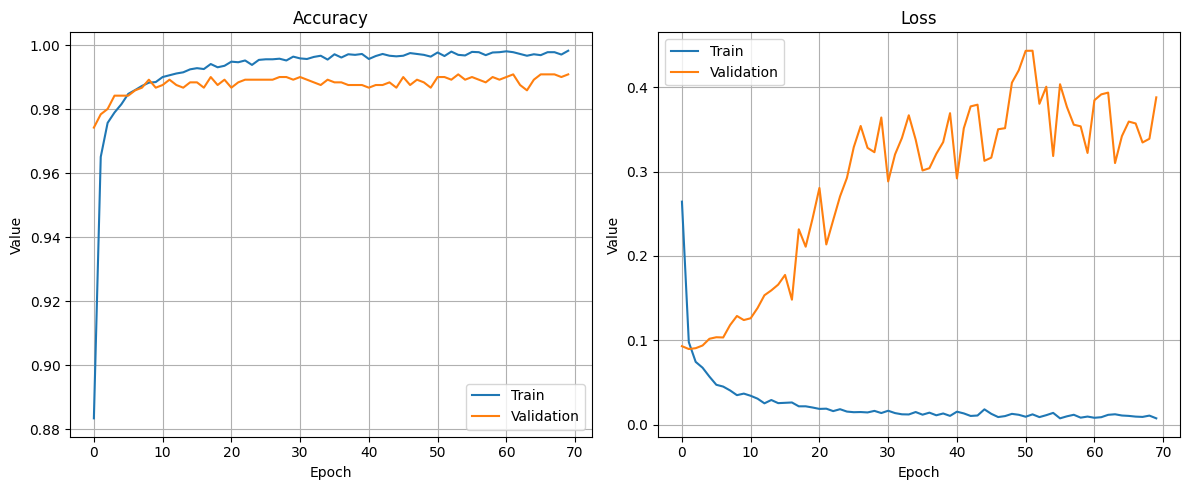

In [5]:

model_malware = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_malware.compile(optimizer=Adam(learning_rate=0.001),
                        loss='binary_crossentropy',
                        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history_malware = model_malware.fit(X_train, y_train,
                                    epochs=70,
                                    batch_size=64,
                                    validation_split=0.1,
                                    verbose=0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_malware.history['accuracy'])
plt.plot(history_malware.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_malware.history['loss'])
plt.plot(history_malware.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Train', 'Validation'])
plt.grid()

plt.tight_layout()
plt.show()

Loss: 0.0891
Accuracy: 0.9907
Precision: 0.9905
Recall: 0.9947

Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      0.98      0.99      1112
     Malware       0.99      0.99      0.99      1896

    accuracy                           0.99      3008
   macro avg       0.99      0.99      0.99      3008
weighted avg       0.99      0.99      0.99      3008



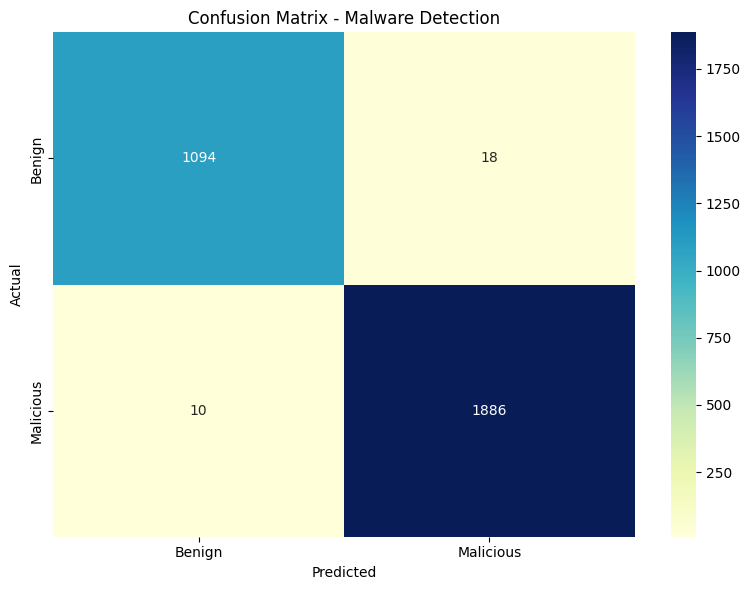

In [6]:
loss_m, accuracy_m, precision_m, recall_m = model_malware.evaluate(X_test, y_test, verbose=0)

y_pred_proba_m = model_malware.predict(X_test, verbose=0)
y_pred_m = (y_pred_proba_m > 0.5).astype(int)

cm_m = confusion_matrix(y_test, y_pred_m)
cr_m = classification_report(y_test, y_pred_m, target_names=['Benign', 'Malware'])

print(f"Loss: {loss_m:.4f}")
print(f"Accuracy: {accuracy_m:.4f}")
print(f"Precision: {precision_m:.4f}")
print(f"Recall: {recall_m:.4f}")
print("\nClassification Report:\n", cr_m)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_m, annot=True, fmt='d', cmap='YlGnBu', xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
plt.title("Confusion Matrix - Malware Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()